In [2]:
import numpy as np
import math
import random
from numpy.random import default_rng
rng = default_rng() # random number generator
import copy

In [59]:
# set up parameters 
u0 = 1e-6 # mutation rate of chromosome
u1 = 1e-4 # mutation rate of gene locus
a = 0.05 # gene gain rate 
b = 0.02 # gene loss rate 
n = 10 # number of initial copies, must be greater than 5 to push the program to run
l = 100 # length of the gene sequence (AA)

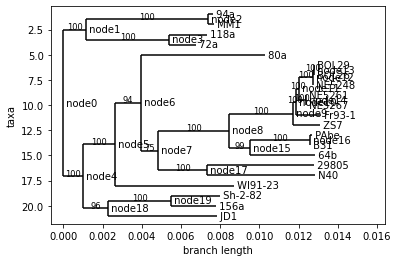

In [30]:
from Bio import Phylo
tree = Phylo.read("Bb_genome_reduced.tree", "newick") # genome tree of B.burgdorferi
internal_clades = tree.get_nonterminals()
for i in range(len(internal_clades)):
    internal_clades[i].name = "node%i" %i # name internal nodes
Phylo.draw(tree)

In [6]:
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order="level"):
        for child in clade:
            parents[child.name] = clade
    return parents

In [7]:
def random_protein_sequence(l, n):
    AA = ('A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V')
    copies = {}
    copy = ''.join(np.random.choice(AA) for _ in range(l))
    for i in range(n):
        gene_id = 'gene%i' %i
        copies[gene_id] = copy   
    return copies 

In [8]:
def mutation(genes, prob):
    for name, seq in genes.items(): # for each gene,
        n_mut =  rng.poisson(prob) # determine how many sites to be mutated
        if n_mut > 0:
            seq = list(seq) # convert string to list in order to subscribe
            sites_mut = random.sample(range(l), n_mut) # choose the sites to mutate
            for site in sites_mut: # mutate the sites one by one
                AA = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
                ori = seq[site]
                AA.remove(ori) # remove the original letter to avoid sampling the same letter
                seq[site] = np.random.choice(AA) # random substitution
            genes[name] = ''.join(seq)
    return(genes) 

In [9]:
def duplication(genes, prob):
    n_gain = rng.poisson(prob) # determine how many genes to be duplicated
    if n_gain > 0:
        gene_gain = random.sample(list(genes), n_gain) # choose the genes to duplicate 
        for gene in gene_gain:
            i = 1
            name = '%s_%i' %(gene, i)
            while name in genes: # check if name is already there
                i += 1 
                name = '%s_%i' %(gene, i) # create a new name
            genes[name] = genes[gene] # add new copy to the dict
    return(genes)

In [10]:
def deletion(genes, prob):
    n_loss = rng.poisson(prob) # determine how many genes to be deleted
    if n_loss > 0:
        gene_loss = random.sample(list(genes), n_loss) # choose the genes to delete
        for item in gene_loss: # remove items from the dict one by one
            genes.pop(item)
    return(genes)

In [11]:
import textwrap
def write_fasta(dictionary, filename):
    with open(filename, "w") as outfile:
        for key, value in dictionary.items():
            outfile.write(">" + key + "\n")
            outfile.write("\n".join(textwrap.wrap(value, 60)))
            outfile.write("\n")

In [53]:
### Main body of the simulator ###
# initiation 
root = random_protein_sequence(l, n)
tree_dic = {}
tree_dic['node0'] = root # a nesting dictionary

# tree_walking and evolution
allclades = list(tree.find_clades(order="level"))
parents = all_parents(tree)

for clade in allclades[1:]: # except the root 
    time = clade.branch_length/u0 # convert branch length to time
    p_mut = 1 - math.exp(-(u1*time)) # probability of mutation
    p_gain = (a/(a+b))*(1-math.exp(-((a+b)*time))) # probability of gain
    p_loss = 1 - p_gain # probability of loss
    
    parent = parents[clade.name].name # retrieve the name of the parent node
    genes = tree_dic[parent] # retrieve parent's gene set
    genes = mutation(genes, p_mut) 
    genes = duplication(genes, p_gain) 
    genes = deletion(genes, p_loss)
    genes2 = genes.copy()
    tree_dic[clade.name] = genes2 # add new gene set to the dict
            
print("Simulation is done!")    

Simulation is done!
Success! File written


In [57]:
# extract terminal names and sequences
tips = [tip.name for tip in tree.get_terminals()]
seq_dic = {}
for taxon in tips:
    for name, seq in tree_dic[taxon].items():
        seq_dic["%s_%s" %(taxon, name)] = seq
    
# export simulated sequences to a fasta file
write_fasta(seq_dic, "bb_vls_sim.fas")
print("Success! File written") 


Success! File written


In [56]:
### Main simulator by recursive tree walking ###
root_genes = random_protein_sequence(l, n)
tree_dic = {}

# recursive function to walk a tree
def walk_tree(clade):
    print(clade.name)
    if clade == tree.root:
        tree_dic[clade.name] = root_genes
    else:
        time = clade.branch_length/u0 # convert branch length to time
        p_mut = 1 - math.exp(-(u1*time)) # probability of mutation
        p_gain = (a/(a+b))*(1-math.exp(-((a+b)*time))) # probability of gain
        p_loss = 1 - p_gain # probability of loss
        
        parent = parents[clade.name].name
        genes = tree_dic[parent] # parent's gene set
        genes = mutation(genes, p_mut) 
        genes = duplication(genes, p_gain) 
        genes = deletion(genes, p_loss)
        genes2 = genes.copy()
        tree_dic[clade.name] = genes2 # add new genes to the dic
    
    if clade.is_terminal(): # stop at a terminal
        return
    else: # recurse for an internal node
        for child in clade:
            walk_tree(child)

# simulate by recursive walk from the root
walk_tree(tree.root)

node0
node1
node2
94a
MM1
node3
118a
72a
node4
node5
node6
80a
node7
node8
node9
node10
node11
node12
node13
BOL29
BOL26
NE5248
node14
NE5261
NE5267
Fr93-1
ZS7
node15
node16
PAbe
B31
64b
node17
29805
N40
WI91-23
node18
node19
Sh-2-82
156a
JD1


In [58]:
!bioseq -n bb_vls_sim.fas
!fasttree bb_vls_sim.fas > bb_vls_sim.tree

241
FastTree Version 2.1.10 Double precision (No SSE3)
Alignment: bb_vls_sim.fas
Amino acid distances: BLOSUM45 Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jones-Taylor-Thorton, CAT approximation with 20 rate categories
Initial topology in 0.02 seconds
Refining topology: 28 rounds ME-NNIs, 2 rounds ME-SPRs, 14 rounds ML-NNIs
Total branch-length 3.210 after 0.17 sec, 101 of 276 nodes   
ML-NNI round 1: LogLk = -2489.580 NNIs 28 max delta 0.00 Time 0.82anges (max delta 0.003)   
Switched to using 20 rate categories (CAT approximation)15 of 20   
Rate categories were divided by 0.831 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -2439.809 NNIs 40 max delta 0.00 Time 1.84anges (max delta 0.000)   
Turning off heuristics for final round of ML NNIs

In [17]:
from Bio import AlignIO
from Bio.Phylo.Applications import PhymlCommandline

In [ ]:
AlignIO.convert("bb_vls_sim.fas", "fasta", "bb_vls_sim.phy", "phylip-relaxed")
cmdline = PhymlCommandline(
    input="bb_vls_sim.phy", datatype="aa", model="WAG", alpha="e", bootstrap=0
)
out_log, err_log = cmdline()

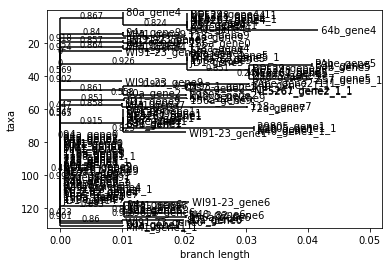

In [14]:
tree_sim = Phylo.read("bb_vls_sim.tree", "newick")
Phylo.draw(tree_sim)

In [22]:
len(tips)

21